In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
# Running the model
 
import jax
from jcm.speedy_test_model import SpeedyTestModel
from dinosaur import primitive_equations_states
from dataclasses import asdict

# Use this if you're debugging, so you can print values etc
# jax.config.update('jax_disable_jit', True)

# As well as these if needed
# jax.config.update("jax_debug_infs", True)
# jax.config.update("jax_debug_nans", True)

model = SpeedyTestModel(time_step=120, save_interval=1, total_time=4, layers=8)

state = model.get_initial_state()
state.tracers = {
    'specific_humidity': primitive_equations_states.gaussian_scalar(
        model.coords, model.physics_specs
    )
}

final_state, predictions = model.unroll(state)

# check for nans
print(final_state)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


State(vorticity=Array([[[ 0.00000000e+00,  4.46460163e-03, -2.95404092e-08, ...,
          6.90297491e-31, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.08475201e-10,  3.20580426e-07, ...,
          6.36701923e-34, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -1.53456844e-10, -3.53008744e-07, ...,
          4.04415010e-34,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.87319419e-35, -0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  6.68189162e-03, -3.58291530e-08, ...,
          5.90637989e-30,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.41543971e-10,  2.42505990e-07, ...,
         -5.25863229e-

In [3]:
# ds = model.data_to_xarray(asdict(predictions))
# ds.to_netcdf("model_state.nc")

In [4]:
from dinosaur import primitive_equations as pe

coords = model.coords

diagnostic_final_state = pe.compute_diagnostic_state(final_state, coords)
vertical_velocity = pe.compute_vertical_velocity(final_state, coords)

print('Computed nodal quantities:\n' + '\n'.join(diagnostic_final_state.__dataclass_fields__.keys()))

Computed nodal quantities:
vorticity
divergence
temperature_variation
cos_lat_u
sigma_dot_explicit
sigma_dot_full
cos_lat_grad_log_sp
u_dot_grad_log_sp
tracers


In [5]:
from dinosaur import spherical_harmonic as sh

log_surface_pressure_nodal = coords.horizontal.to_nodal(final_state.log_surface_pressure)
u_nodal, v_nodal = sh.vor_div_to_uv_nodal(coords.horizontal, final_state.vorticity, final_state.divergence)
w_nodal = pe.compute_vertical_velocity(final_state, coords)

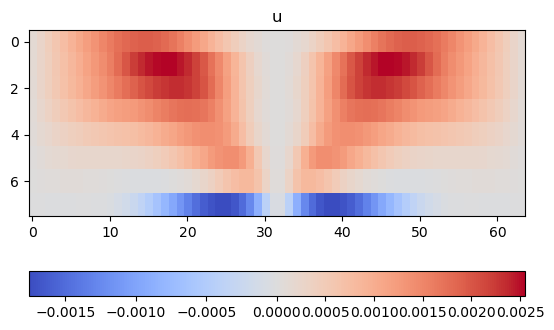

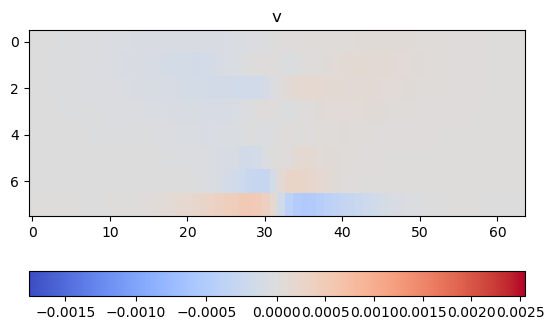

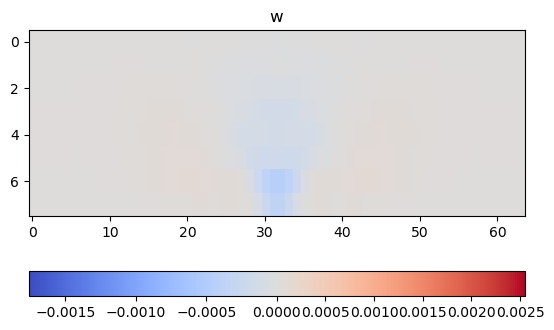

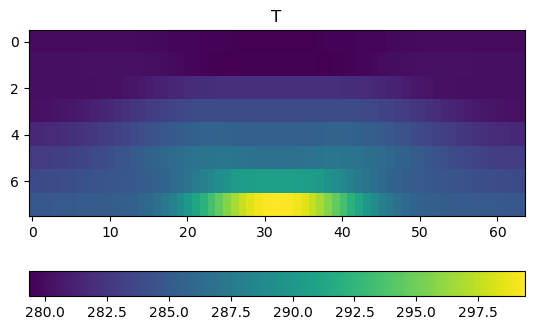

In [8]:
from matplotlib.colors import TwoSlopeNorm

norm = TwoSlopeNorm(vcenter=0)

plt.imshow(np.mean(u_nodal, axis=1), cmap='coolwarm', norm=norm, aspect=3)
plt.title('u')
plt.colorbar(orientation='horizontal')
plt.show()

plt.imshow(np.mean(v_nodal, axis=1), cmap='coolwarm', norm=norm, aspect=3)
plt.title('v')
plt.colorbar(orientation='horizontal')
plt.show()

plt.imshow(np.mean(w_nodal, axis=1), cmap='coolwarm', norm=norm, aspect=3)
plt.title('w')
plt.colorbar(orientation='horizontal')
plt.show()

temperature_nodal = model.ref_temps[:, None, None] + diagnostic_final_state.temperature_variation
plt.imshow(np.mean(temperature_nodal, axis=1), cmap='viridis', aspect=3)
plt.title('T')
plt.colorbar(orientation='horizontal')
plt.show()

# plt.imshow(np.mean(diagnostic_final_state.tracers['specific_humidity'], axis=1), cmap='viridis', aspect=3)
# plt.title('q')
# plt.colorbar(orientation='horizontal')
# plt.show()

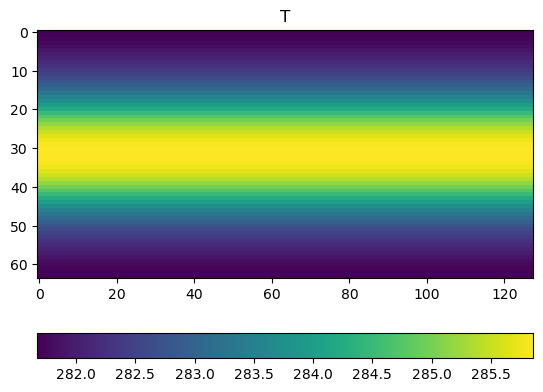

In [11]:
plt.imshow(np.mean(temperature_nodal, axis=0).T, cmap='viridis', aspect='equal')
plt.title('T')
plt.colorbar(orientation='horizontal')
plt.show()

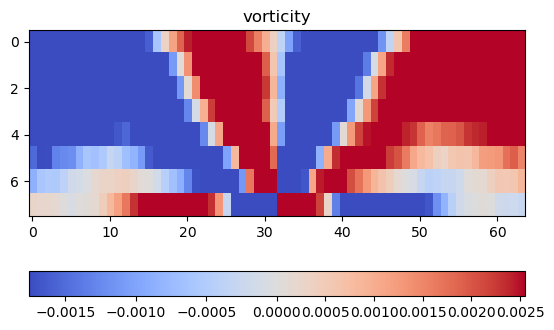

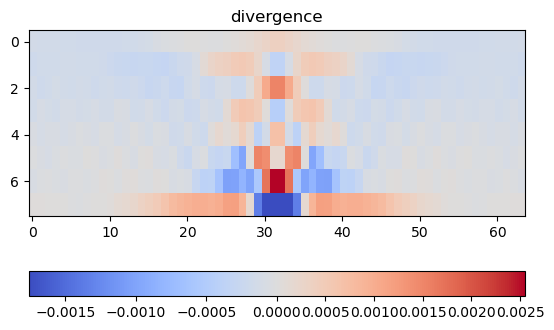

In [7]:
plt.imshow(np.mean(diagnostic_final_state.vorticity, axis=1), cmap='coolwarm', norm=norm, aspect=3)
plt.title('vorticity')
plt.colorbar(orientation='horizontal')
plt.show()

plt.imshow(np.mean(diagnostic_final_state.divergence, axis=1), cmap='coolwarm', norm=norm, aspect=3)
plt.title('divergence')
plt.colorbar(orientation='horizontal')
plt.show()